In [1]:
# EDA 사전 준비사항
%matplotlib inline

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import seaborn as sns  #데이터 시각화 
from sklearn import preprocessing
sns.set(font="AppleGothic", 

        rc={"axes.unicode_minus":False},

        style='darkgrid')

In [2]:
train = pd.read_csv('/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/train.csv')

In [3]:
train['game_id'].unique()
train['time'].max()

10.59

In [4]:
data = train[train['game_id']==8]

In [5]:
data.head()

,game_id,winner,time,player,species,event,event_contents
15972,8,1,0.00,0,T,Camera,"at (24.75, 128.01171875)"
15973,8,1,0.00,1,Z,Camera,"at (151.25, 20.5078125)"
15974,8,1,0.01,1,Z,Selection,['Hive [3440001]']
15975,8,1,0.02,1,Z,Selection,"['Egg [3480001]', 'Egg [34C0001]', 'Egg [35000..."
15976,8,1,0.04,1,Z,AddToControlGroup,NaN


In [6]:
temp = [0, 0.3, 1, 1.3, 2, 2.3, 3, 3.3, 4, 4.3,
       5, 5.3, 6, 6.3, 7, 7.3, 8, 8.3, 9, 9.3,10]
for i in range(0,20):
    data.loc[(data['time']>=temp[i])]

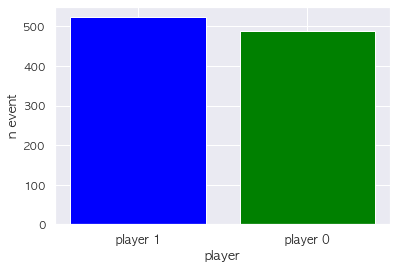

In [7]:
#선수별 event 수

label = ['player 1', 'player 0']
index = np.arange(len(label))  
plt.bar(index, data['player'].value_counts(), color=('blue','green'))
plt.xlabel('player', fontsize=13)
plt.ylabel('n event', fontsize=13)
plt.xticks(index, label, fontsize=12)
plt.show()

<AxesSubplot:xlabel='time'>

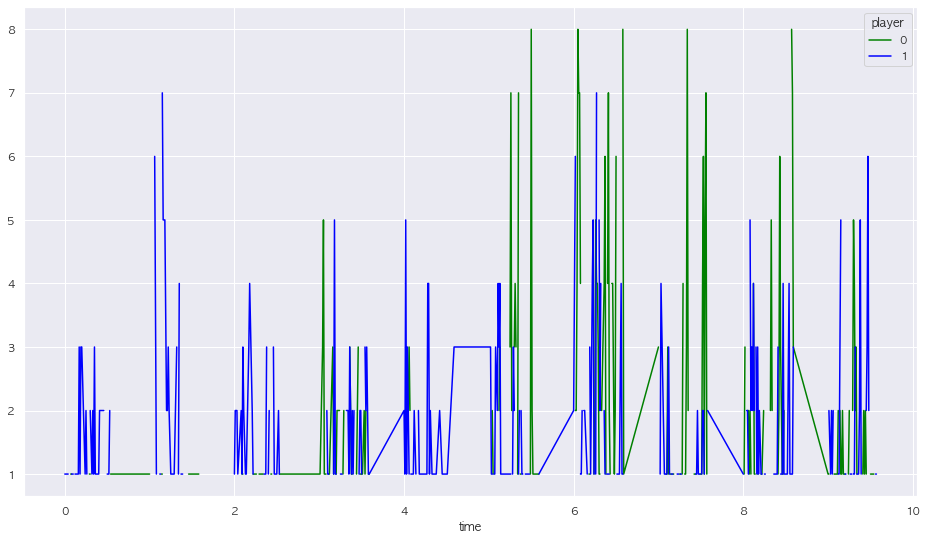

In [8]:
#선수별 시간별 event 수
fig, ax = plt.subplots(figsize=(16,9))
data.groupby(['time','player']).count()['event'].unstack().plot(ax=ax, color=('green','blue'))

<AxesSubplot:xlabel='event'>

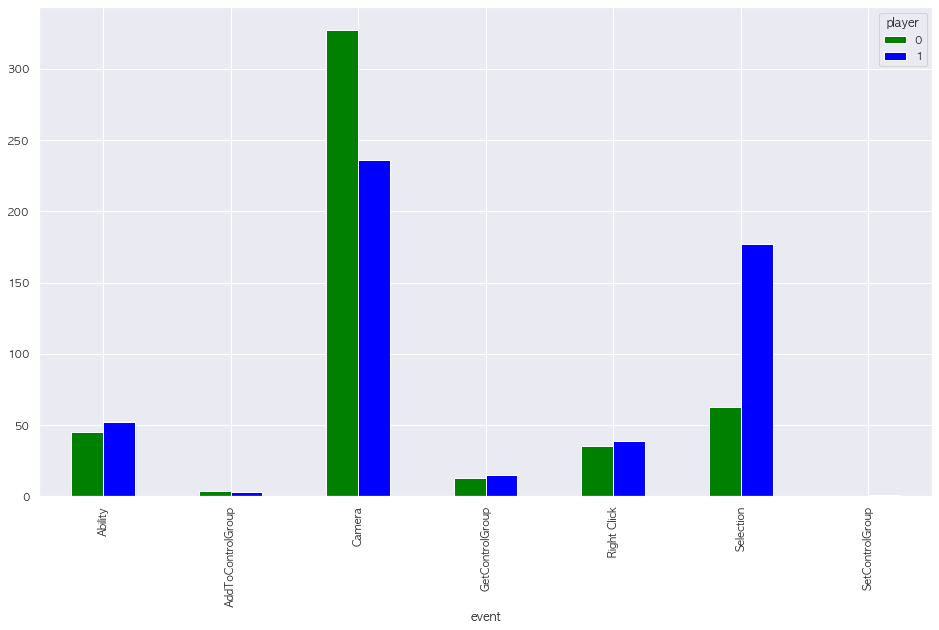

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
data.groupby(['event','player']).count()['winner'].unstack().plot(ax=ax, color=('green','blue'),kind='bar')

In [1]:
# 라이브러리 설치

import warnings                                      # 경고 메세지 무시
warnings.filterwarnings('ignore')
import pandas as pd                                  # 데이터 조작, 분석
import numpy as np                                   # 행렬 연산
import random                                        # 난수 생성
random.seed(2020)
random_seed = 2020
import time                                          # 시간 측정
import re                                            # 정규표현식

from sklearn.model_selection import train_test_split # train, validation 데이터 나누기
from sklearn import metrics                          # AUC 측정
!pip install catboost
from catboost import CatBoostClassifier, Pool        # CatBoost 모델링
import lightgbm as lgb                               # lightGBM 모델링
from sklearn.model_selection import KFold            # K-fold CV    
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization           # 베이지안 최적화 라이브러리  
from functools import partial      


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
train = pd.read_csv("/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/train.csv")
test = pd.read_csv("/Users/choejeehyuk/경4났조/235583_행동 데이터 분석 인공지능 AI 경진대회_data/test.csv")

In [18]:
# 반응변수 전처리
def preprocess_y(data, exchange_player=False):
  y = data.drop_duplicates(['game_id', 'winner']).winner.reset_index(drop=True)
  if (exchange_player == True):
    y = y.append(-(y - 1)).reset_index(drop=True)
  return y

In [19]:
# 설명변수 전처리
def preprocess_X(data, exchange_player=False):

  # game_id 개수만큼의 index를 가진 DataFrame X 생성
  n = data.game_id.max() + 1
  X = pd.DataFrame(index=range(n)[data.game_id.min():])

  # time 변수
  X['time'] = data.drop_duplicates(['game_id'],keep='last').set_index('game_id').time
  X['time'] = (X.time*100//100*60 + X.time*100%100).astype(int)

  # species 더미 변수
  X = pd.concat([pd.get_dummies(data[data.player == 0].drop_duplicates(['game_id']).set_index('game_id').species).rename(columns={'P':'0_protoss','T':'0_terran','Z':'0_zerg'}),
                pd.get_dummies(data[data.player == 1].drop_duplicates(['game_id']).set_index('game_id').species).rename(columns={'P':'1_protoss','T':'1_terran','Z':'1_zerg'}),
                X],axis=1)
  
  # event 카운트
  contents = data.loc[:,['player','game_id','time']].groupby(['player', 'game_id']).count().unstack(level=0)
  contents.columns = ['0_event', '1_event']
  X['0_event'], X['1_event'] = contents['0_event'], contents['1_event']

  # event 카운트 / time
  X['0_event_per_sec'], X['1_event_per_sec'] = X['0_event'] /X.time, X['1_event'] /X.time

  # event == Ability, AddToControlGroup, Camera, ControlGroup, GetControlGroup, Right Click, Selection, SetControlGroup일 때 각각 카운트
  contents = data.loc[:,['player','event','game_id','time']].groupby(['player', 'event', 'game_id']).count().unstack(level=[0,1]).fillna(0).astype(int)
  contents.columns = ['0_'+x for x in sorted(data.event.unique())] + ['1_'+x for x in sorted(data.event.unique())]
  for i in contents.columns:
    X[i] = contents[i]

In [21]:
# event == Camera일 때 event_contents의 2차원 좌표 간 euclidean distance sum, min, median, max
def move_sum(i):
    return sum(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))

In [22]:
def move_min(i):
    if len(i) == 1:
      return 0
    return min(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 +
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))

In [23]:
def move_median(i):
    if len(i) == 1:
      return 0
    return np.median(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 + 
                             np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))

In [29]:
def move_max(i):
    if len(i) == 1:
        return 0
    return max(np.sqrt(np.diff(i.map(lambda x: x[4:x.find(',')]).astype(float)) **2 +
                       np.diff(i.map(lambda x: x[x.find(',')+2:len(x)-1]).astype(float)) **2))
    contents = (data[data.event == 'Camera'].loc[:,['player','game_id','event_contents']].groupby(['player','game_id'])).agg([move_sum,move_min,move_median,move_max]).unstack(level=0)
    contents.columns = [y+x for x in ['sum','min','median','max'] for y in ['0_move_','1_move_']]
    for i in contents.columns:
        X[i] = contents[i].fillna(0)

  # 30초 이내 move_sum
    contents = (data[data.time < (data.event == 'Camera')].loc[:,['player','game_id','event_contents']].groupby(['player','game_id'])).agg(move_sum).unstack(level=0)
    contents.columns = ['0_move_sum_30sec','1_move_sum_30sec']
    for i in contents.columns:
        X[i] = contents[i]

  # event == Ability일 때 event_contents 더미 변수 생성, 카운트
    contents = pd.DataFrame(data.event_contents[(data.event == 'Ability')].map(lambda x: x[x.find('(')+1:x.find(')')]))  # event_contents의 16진수 코드만 추출
    contents['game_id'], contents['player'], contents['count'] = data.game_id, data.player, 1
    contents_X = pd.DataFrame(columns=[x+y for x in ['0_','1_'] for y in contents.event_contents.unique()])
    contents = contents.groupby(['player','event_contents','game_id']).count().unstack(level=[0,1])
    contents.columns = contents.columns.map(lambda x: str(x[1])+'_'+x[2])
    contents_X = pd.concat([contents_X, contents])
    for i in contents_X.columns:
        X[i] = contents_X[i]
        X[i] = X[i].fillna(0).astype(int)

  # event == Ability일 때 event_contents 더미 변수 생성 / time
    for i in contents_X.columns:
        X[i+'_div_time'] = X[i] /X.time

  # event == Selection일 때 event_contents 더미 변수 생성, 카운트
    contents = data[data.event == 'Selection'].event_contents.map(lambda x: re.sub('\s\[.....\]', '', re.sub('\s\[......\]', '', re.sub('\s\[.......\]', '', x))).replace('[', '').replace(']', '').replace(' ', '').replace('\'', ''))
    contents = contents.str.split(',')
    max_num = max(contents.map(lambda x: len(x)))
    t = [0 for x in range(max_num)]
    for i in range(max_num):
        t[i] = pd.DataFrame(contents[contents.map(lambda x: len(x) > i)].map(lambda x: x[i]))
    contents = pd.concat([t[i] for i in range(max_num)])
    contents['game_id'], contents['player'], contents['count'] = data.game_id, data.player, 1
    contents_X = pd.DataFrame(columns=[x+y for x in ['0_','1_'] for y in contents.event_contents.unique()])
    contents = contents.groupby(['player','event_contents','game_id']).count().unstack(level=[0,1])
    contents.columns = contents.columns.map(lambda x: str(x[1])+'_'+x[2])
    contents_X = pd.concat([contents_X, contents])
    for i in contents_X.columns:
        X[i] = contents_X[i]
        X[i] = X[i].fillna(0).astype(int)

  # event == Selection일 때 event_contents 더미 변수 생성 / time
    for i in contents_X.columns:
        X[i+'_div_time'] = X[i] /X.time

  # 30초 이내 event == Selection일 때 event_contents 더미 변수 생성, 카운트
    contents = data[data.time < (data.event == 'Selection')].event_contents.map(lambda x: re.sub('\s\[.....\]', '', re.sub('\s\[......\]', '', re.sub('\s\[.......\]', '', x))).
                                                                                      replace('[', '').replace(']', '').replace(' ', '').replace('\'', ''))
    contents = contents.str.split(',')
    max_num = max(contents.map(lambda x: len(x)))
    t = [0 for x in range(max_num)]
    for i in range(max_num):
        t[i] = pd.DataFrame(contents[contents.map(lambda x: len(x) > i)].map(lambda x: x[i]))
    contents = pd.concat([t[i] for i in range(max_num)])
    contents['game_id'], contents['player'], contents['count'] = data.game_id, data.player, 1
    contents_X = pd.DataFrame(columns=[x+y for x in ['0_','1_'] for y in contents.event_contents.unique()])
    contents = contents.groupby(['player','event_contents','game_id']).count().unstack(level=[0,1])
    contents.columns = contents.columns.map(lambda x: str(x[1])+'_'+x[2])
    contents_X = pd.concat([contents_X, contents])
    for i in contents_X.columns:
        X[i+'_30sec'] = contents_X[i]
        X[i+'_30sec'] = X[i+'_30sec'].fillna(0).astype(int)

  # event == Right Click일 때 Target 이름 더미 변수 생성, 카운트
    contents = pd.DataFrame(data.event_contents[(data.event == 'Right Click') & (data.event_contents.map(lambda x: str(x)[:6]) == 'Target')].map(lambda x: x[x.find(':')+2:x.find(' [')]))  # event_contents의 Target만 추출
    contents['game_id'], contents['player'], contents['count'] = data.game_id, data.player, 1
    contents_X = pd.DataFrame(columns=[x+y for x in ['0_Target_','1_Target_'] for y in contents.event_contents.unique()])
    contents = contents.groupby(['player','event_contents','game_id']).count().unstack(level=[0,1])
    contents.columns = contents.columns.map(lambda x: str(x[1])+'_Target_'+x[2])
    contents_X = pd.concat([contents_X, contents])
    for i in contents_X.columns:
        X[i] = contents_X[i]
        X[i] = X[i].fillna(0).astype(int)

  # 컬럼 이름 순서로 정렬
    X = X[sorted(X.columns)]

  # player 0,1 자리 바꾼 X1생성, X와 행 병합해 데이터 2배로 만들기
    if (exchange_player == True):
        c = X.shape[1]//2
        X1 = X.copy()
        X1.columns = list(X.columns[c:2*c])+list(X.columns[:c])+['time']
        X1.index = [x+n for x in range(n)]
        X = pd.concat([X, X1])

    return X

In [30]:
# train, test 전처리 수행, y(반응변수), X,test_X(설명변수) 생성
y = preprocess_y(train, True)
X = preprocess_X(train, True)
test_X = preprocess_X(test, False)

# 메모리 효율 위해 train, test raw data 삭제
del train, test

# X, test_X에만 있는 컬럼 삭제
X.drop(set(X.columns) - set(test_X.columns), axis=1, inplace=True)
test_X.drop(set(test_X.columns) - set(X.columns), axis=1, inplace=True)

AttributeError: 'NoneType' object has no attribute 'drop'

In [ ]:
# CatBoost 모델링
def catboost_modeling(x_train, y_train, x_test, grow_policy, depth, learning_rate, l2_leaf_reg, random_seed, n):
  
  # 빈 Series인 test_pred 생성
    test_pred = pd.Series([0 for x in range(len(x_test))], index=x_test.index)
  
  # 10-fold 모델링을 n회 반복할 것
    for i in range(n):
        kf = KFold(n_splits=10, random_state=random_seed+i)
    for train_index, valid_index in kf.split(x_train):
        train_X, train_y = x_train.iloc[train_index], y_train[train_index]
        valid_X, valid_y = x_train.iloc[valid_index], y_train[valid_index]
      
    # catBoost(grow_policy='Depthwise')
    model = CatBoostClassifier(eval_metric = 'AUC',              # AUC로 성능 측정
                                 iterations = 25000,               # 반복횟수 최대 25000
                                 metric_period = 25000,            # 중간결과 출력X
                                 early_stopping_rounds = 1000,     # 1000iteration 동안 AUC 증가 없으면 학습 중단
                                 task_type = 'GPU',                # GPU 사용
                                 grow_policy = grow_policy,        # 트리 노드 생성 방식
                                                                   # 1) Depthwise(지정한 depth에 이를 때까지 level 순으로 노드 분할)
                                                                   # 2) Lossguide(loss 변화가 큰 순으로 노드 분할)
                                 depth = depth,                    # 트리 깊이
                                 learning_rate = learning_rate,    # 러닝레이트
                                 l2_leaf_reg = l2_leaf_reg,        # L2 정규화
                                 random_seed = random_seed+i,      # 랜덤시드 고정
                                 )
      # 모델 학습
    model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
    
      # 모델 적용
    test_pred += model.predict_proba(x_test)[:,1] /(10*n)
    
  # 설정된 디렉토리에 결과물 저장
    sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
    submission = pd.DataFrame(data=test_pred, columns=sample_submission.columns, index=sample_submission.index)
    submission.to_csv('CatBoost_'+grow_policy+'_'+str(depth)+'.csv', index=True)

    return test_pred